In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [1]:
import jax.random as jr

jr.PRNGKey(44)

2024-09-05 15:53:48.857396: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([ 0, 44], dtype=uint32)

In [2]:
pwd

'/home/makinen/repositories/epe_hybrid'

In [1]:
cd wl-sbi/automate_run

/home/makinen/repositories/epe_hybrid/wl-sbi/automate_run


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import tensorflow_probability as tfp
tfp.__version__

'0.24.0'

In [3]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)

2024-09-08 19:47:40.114762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 19:47:40.114790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 19:47:40.115789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 19:47:41.033284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#@title dataloader code
import jax.tree_util
import tensorflow as tf
from jax import Array
from jax import numpy as jnp
from jax import random as jr
from jax._src.flatten_util import ravel_pytree
from typing import Callable

from sbijax._src.util.types import PyTree


# pylint: disable=missing-class-docstring,too-few-public-methods
class DataLoader:
    # noqa: D101
    def __init__(self, itr, num_samples):  # noqa: D107
        self._itr = itr
        self.num_samples = num_samples

    def __iter__(self):
        """Iterate over the data set."""
        yield from self._itr.as_numpy_iterator()


# pylint: disable=missing-function-docstring
def as_batch_iterators(
    rng_key: Array, data: PyTree, batch_size, split, shuffle,
    noise_simulator: Callable = None
):
    """Create two data batch iterators from a data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        batch_size: size of each batch
        split: fraction of data to use for training data set. Rest is used
            for validation data set.
        shuffle: shuffle the data set or no
        noise_simulator: noise simulator with signature f(key, sim)

    Returns:
        returns two iterators
    """
    n = data["y"].shape[0]
    n_train = int(n * split)

    if shuffle:
        idxs = jr.permutation(rng_key, jnp.arange(n))
        data = jax.tree_util.tree_map(lambda x: x[idxs], data)

    y_train = jax.tree_util.tree_map(lambda x: x[:n_train], data)
    y_val = jax.tree_util.tree_map(lambda x: x[n_train:], data)

    train_rng_key, val_rng_key = jr.split(rng_key)




    train_itr = as_batch_iterator(train_rng_key, y_train, batch_size, shuffle, noise_simulator)
    val_itr = as_batch_iterator(val_rng_key, y_val, batch_size, shuffle, noise_simulator)

    return train_itr, val_itr


def as_batched_numpy_iterator_from_tf(
    rng_key: Array, data: tf.data.Dataset, iter_size, batch_size, shuffle
):
    """Create a data batch iterator from a tensorflow data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        iter_size: total number of elements in the data set
        batch_size: size of each batch
        shuffle: shuffle the data set or no

    Returns:
        a tensorflow iterator
    """
    # hack, cause the tf stuff doesn't support jax keys :)
    max_int32 = jnp.iinfo(jnp.int32).max
    seed = jr.randint(rng_key, shape=(), minval=0, maxval=max_int32)

    data = (
        data.shuffle(
            10 * batch_size,
            seed=int(seed),
            reshuffle_each_iteration=shuffle,
        )
        .batch(batch_size)
        .prefetch(buffer_size=batch_size)
    )
    return DataLoader(data, iter_size)


# pylint: disable=missing-function-docstring
def as_batch_iterator(rng_key: Array, data: PyTree, batch_size, shuffle,
                      noise_simulator: Callable = None
                      ):
    """Create a data batch iterator from a data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        batch_size: size of each batch
        shuffle: shuffle the data set or no
        noise_simulator: add noise on top of simulation
    Returns:
        a tensorflow iterator
    """
    y = data["y"]

    if noise_simulator is not None:
        key, rng_key = jr.split(rng_key)
        keys = jr.split(key, num=y.shape[0])
        y = jax.vmap(noise_simulator)(keys, y)

    data = {
        "y": y,
        "theta": jax.vmap(lambda x: ravel_pytree(x)[0])(data["theta"]),
    }
    itr = tf.data.Dataset.from_tensor_slices(data)
    return as_batched_numpy_iterator_from_tf(
        rng_key, itr, data["y"].shape[0], batch_size, shuffle
    )


def as_numpy_iterator_from_slices(data: PyTree, batch_size):
    itr = tf.data.Dataset.from_tensor_slices(data)
    itr = itr.batch(batch_size).prefetch(buffer_size=batch_size)
    itr = itr.as_numpy_iterator()
    return itr

## adapt the mdn code from `sbijax` into flax

In [5]:
from functools import partial

import jax
import numpy as np
import optax
from absl import logging
from jax import numpy as jnp
from jax import random as jr
from jax import scipy as jsp
from jax._src.flatten_util import ravel_pytree
from tqdm import tqdm

from sbijax._src._ne_base import NE
from sbijax._src.util.data import as_inference_data
from sbijax._src.util.early_stopping import EarlyStopping
#from sbijax._src.util.dataloader import as_batch_iterators



# custom dataloader class to support additive noise (or simulator)


# ruff: noqa: PLR0913, E501
class myNPE(NE):
    """Neural posterior estimation.

    Implements the method introduced in :cite:t:`greenberg2019automatic`.
    In the literature, the method is usually referred to as APT or NPE-C, but
    here we refer to it simply as NPE.

    Args:
        model_fns: a tuple of calalbles. The first element needs to be a
            function that constructs a tfd.JointDistributionNamed, the second
            element is a simulator function.
        density_estimator: a (neural) conditional density estimator
            to model the posterior distribution
        num_atoms: number of atomic atoms

    Examples:
        >>> from sbijax import NPE
        >>> from sbijax.nn import make_maf
        >>> from tensorflow_probability.substrates.jax import distributions as tfd
        ...
        >>> prior = lambda: tfd.JointDistributionNamed(
        ...     dict(theta=tfd.Normal(0.0, 1.0))
        ... )
        >>> s = lambda seed, theta: tfd.Normal(theta["theta"], 1.0).sample(seed=seed)
        >>> fns = prior, s
        >>> neural_network = make_maf(1)
        >>> model = NPE(fns, neural_network)

    References:
        Greenberg, David, et al. "Automatic posterior transformation for likelihood-free inference." International Conference on Machine Learning, 2019.
    """

    def __init__(self, model_fns, density_estimator, num_atoms=10):
        """Construct an SNP object.

        Args:
            model_fns: a tuple of tuples. The first element is a tuple that
                    consists of functions to sample and evaluate the
                    log-probability of a data point. The second element is a
                    simulator function.
            density_estimator: a (neural) conditional density estimator
                to model the posterior distribution
            num_atoms: number of atomic atoms
        """
        super().__init__(model_fns, density_estimator)
        self.num_atoms = num_atoms
        self.n_round = 0

    # ruff: noqa: D417
    def fit(
        self,
        rng_key,
        data,
        *,
        noise_simulator=None,
        optimizer=optax.adam(0.0003),
        n_iter=1000,
        batch_size=128,
        percentage_data_as_validation_set=0.1,
        n_early_stopping_patience=10,
        **kwargs,
    ):
        """Fit an SNP model.

        Args:
            rng_key: a jax random key
            data: data set obtained from calling
                `simulate_data_and_possibly_append`
            noise_simulator: noise function with signature `data_noise = fn(key, data)`
            optimizer: an optax optimizer object
            n_iter: maximal number of training iterations per round
            batch_size:  batch size used for training the model
            percentage_data_as_validation_set: percentage of the simulated
                data that is used for validation and early stopping
            n_early_stopping_patience: number of iterations of no improvement
                of training the flow before stopping optimisation


        Returns:
            a tuple of parameters and a tuple of the training information
        """
        itr_key, rng_key = jr.split(rng_key)
        train_iter, val_iter = self.as_iterators(
            itr_key, data, batch_size, percentage_data_as_validation_set,
            noise_simulator
        )
        params, losses = self._fit_model_single_round(
            seed=rng_key,
            train_iter=train_iter,
            val_iter=val_iter,
            optimizer=optimizer,
            n_iter=n_iter,
            n_early_stopping_patience=n_early_stopping_patience,
            n_atoms=self.num_atoms,
        )

        return params, losses

    # pylint: disable=undefined-loop-variable
    def _fit_model_single_round(
        self,
        seed,
        train_iter,
        val_iter,
        optimizer,
        n_iter,
        n_early_stopping_patience,
        n_atoms,
    ):
        init_key, seed = jr.split(seed)
        params = self._init_params(init_key, **next(iter(train_iter)))
        state = optimizer.init(params)

        n_round = self.n_round
        if n_round == 0:

            def loss_fn(params, rng, **batch):
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=batch["theta"],
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(params, rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params,
                    rng,
                    n_atoms,
                    theta=batch["theta"],
                    y=batch["y"],
                )
                return -jnp.mean(lp)

        @jax.jit
        def step(params, rng, state, **batch):
            loss, grads = jax.value_and_grad(loss_fn)(params, rng, **batch)
            updates, new_state = optimizer.update(grads, state, params)
            new_params = optax.apply_updates(params, updates)
            return loss, new_params, new_state

        losses = np.zeros([n_iter, 2])
        early_stop = EarlyStopping(1e-3, n_early_stopping_patience)
        best_params, best_loss = None, np.inf
        logging.info("training model")
        for i in tqdm(range(n_iter)):
            train_loss = 0.0
            rng_key = jr.fold_in(seed, i)
            for batch in train_iter:
                train_key, rng_key = jr.split(rng_key)
                batch_loss, params, state = step(
                    params, train_key, state, **batch
                )
                train_loss += batch_loss * (
                    batch["y"].shape[0] / train_iter.num_samples
                )
            val_key, rng_key = jr.split(rng_key)
            validation_loss = self._validation_loss(
                val_key, params, val_iter, n_atoms
            )
            losses[i] = jnp.array([train_loss, validation_loss])

            _, early_stop = early_stop.update(validation_loss)
            if early_stop.should_stop:
                logging.info("early stopping criterion found")
                break
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_params = params.copy()

        self.n_round += 1
        losses = jnp.vstack(losses)[: (i + 1), :]
        return best_params, losses

    def _init_params(self, rng_key, **init_data):
        params = self.model.init(
            rng_key, method="log_prob", y=init_data["theta"], x=init_data["y"]
        )
        return params

    def _proposal_posterior_log_prob(self, params, rng, n_atoms, theta, y):
        n = theta.shape[0]
        n_atoms = np.maximum(2, np.minimum(n_atoms, n))
        repeated_y = jnp.repeat(y, n_atoms, axis=0)
        probs = jnp.ones((n, n)) * (1 - jnp.eye(n)) / (n - 1)

        choice = partial(
            jr.choice, a=jnp.arange(n), replace=False, shape=(n_atoms - 1,)
        )
        sample_keys = jr.split(rng, probs.shape[0])
        choices = jax.vmap(lambda key, prob: choice(key, p=prob))(
            sample_keys, probs
        )
        contrasting_theta = theta[choices]

        atomic_theta = jnp.concatenate(
            (theta[:, None, :], contrasting_theta), axis=1
        )
        atomic_theta = atomic_theta.reshape(n * n_atoms, -1)

        log_prob_posterior = self.model.apply(
            params, None, method="log_prob", y=atomic_theta, x=repeated_y
        )
        log_prob_posterior = log_prob_posterior.reshape(n, n_atoms)
        log_prob_prior = self.prior_log_density_fn(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(n, n_atoms)

        unnormalized_log_prob = log_prob_posterior - log_prob_prior
        log_prob_proposal_posterior = unnormalized_log_prob[
            :, 0
        ] - jsp.special.logsumexp(unnormalized_log_prob, axis=-1)

        return log_prob_proposal_posterior

    def _validation_loss(self, rng_key, params, val_iter, n_atoms):
        if self.n_round == 0:

            def loss_fn(rng, **batch):
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=batch["theta"],
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params, rng, n_atoms, batch["theta"], batch["y"]
                )
                return -jnp.mean(lp)

        def body_fn(batch, rng_key):
            loss = jax.jit(loss_fn)(rng_key, **batch)
            return loss * (batch["y"].shape[0] / val_iter.num_samples)

        loss = 0.0
        for batch in val_iter:
            val_key, rng_key = jr.split(rng_key)
            loss += body_fn(batch, val_key)
        return loss

    @staticmethod
    def as_iterators(
        rng_key, data, batch_size, percentage_data_as_validation_set,
        noise_simulator
    ):
        """Convert the data set to an iterable for training.

        Args:
            rng_key: a jax random key
            data: a tuple with 'y' and 'theta' elements
            batch_size: the size of each batch
            percentage_data_as_validation_set: fraction

        Returns:
            two batch iterators
        """
        print("hooray")
        return as_batch_iterators(
            rng_key,
            data,
            batch_size,
            1.0 - percentage_data_as_validation_set,
            True,
            noise_simulator
        )

    def sample_posterior(
        self, rng_key, params, observable, *, n_samples=4_000, **kwargs
    ):
        r"""Sample from the approximate posterior.

        Args:
            rng_key: a jax random key
            params: a pytree of neural network parameters
            observable: observation to condition on
            n_samples: number of samples to draw

        Returns:
            returns an array of samples from the posterior distribution of
            dimension (n_samples \times p)
        """
        observable = jnp.atleast_2d(observable)

        thetas = None
        n_curr = n_samples
        n_total_simulations_round = 0
        _, unravel_fn = ravel_pytree(self.prior_sampler_fn(seed=jr.PRNGKey(1)))
        while n_curr > 0:
            n_sim = jnp.minimum(200, jnp.maximum(200, n_curr))
            n_total_simulations_round += n_sim
            sample_key, rng_key = jr.split(rng_key)
            proposal = self.model.apply(
                params,
                sample_key,
                method="sample",
                sample_shape=(n_sim,),
                x=jnp.tile(observable, [n_sim, 1]),
            )
            proposal_probs = self.prior_log_density_fn(
                jax.vmap(unravel_fn)(proposal)
            )
            proposal_accepted = proposal[jnp.isfinite(proposal_probs)]
            if thetas is None:
                thetas = proposal_accepted
            else:
                thetas = jnp.vstack([thetas, proposal_accepted])
            n_curr -= proposal_accepted.shape[0]
        self.n_total_simulations += n_total_simulations_round

        ess = float(thetas.shape[0] / n_total_simulations_round)
        thetas = jax.tree_map(
            lambda x: x.reshape(1, *x.shape),
            jax.vmap(unravel_fn)(thetas[:n_samples]),
        )
        inference_data = as_inference_data(thetas, jnp.squeeze(observable))
        return inference_data, ess

In [6]:
from collections.abc import Iterable
from typing import Callable, Sequence

import haiku as hk
import haiku.experimental.flax as hkflax
import flax.linen as nn
import jax
from jax import numpy as jnp
from tensorflow_probability.substrates.jax import distributions as tfd



# pylint: disable=too-many-arguments
def my_make_mdn(
    n_dimension: int,
    n_components: int,
    hidden_sizes: Iterable[int] = (64, 64),
    activation: Callable = jax.nn.relu,
    embedding_net: nn.Module = None
):
    """Create an affine masked autoregressive flow.

    The MAFs use `n_layers` layers and are parameterized using MADE networks
    with `hidden_sizes` neurons per layer.

    Args:
        n_dimension: dimensionality of theta
        n_components: number of mixture components
        hidden_sizes: sizes of hidden layers for each normalizing flow. E.g.,
            when the hidden sizes are a tuple (64, 64), then each maf layer
            uses a MADE with two layers of size 64 each
        activation: a jax activation function

    Returns:
        a normalizing flow model
    """

    @hk.transform
    def mdn(method, **kwargs):
        n = kwargs["x"].shape[0]
        x = jnp.array(kwargs["x"])

        #print("x mdn input", x.shape)

        # optional embedding network
        if embedding_net is not None:
          mod = hkflax.lift(embedding_net, name='flax_embedding_net')
          # add in a vmap here
          x = jax.vmap(mod)(x)

        xembed = x
        # rest of network
        hidden = hk.nets.MLP(
            hidden_sizes, activation=activation, activate_final=True
        )(x)
        #print("hidden", hidden.shape)
        logits = hk.Linear(n_components)(hidden)
        mu_sigma = hk.Linear(n_components * n_dimension * 2)(hidden)
        mu, sigma = jnp.split(mu_sigma, 2, axis=-1)

        mixture = tfd.MixtureSameFamily(
            tfd.Categorical(logits=logits),
            tfd.MultivariateNormalDiag(
                mu.reshape(n, n_components, n_dimension),
                jnp.exp(sigma.reshape(n, n_components, n_dimension)),
            ),
        )
        if method == "sample":
            return mixture.sample(seed=hk.next_rng_key())
        elif method == "embedding":
            # could also return logits, mu_sigma
            return xembed
        else:
            return mixture.log_prob(kwargs["y"])

    return mdn



In [7]:
#@title config code
import sys,os
import yaml
import jax_cosmo as jc

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import sys,os
import yaml

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


# -----
# folder to load config file
CONFIG_PATH = "./config"

config_name = "config_N128.yaml"
noiseamp = 0.125

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config(config_name)
# -----


# -----
# UNPACK GLOBAL CONFIG VALUES
outdir = config["datadir"]
N = config["N"]
L = config["L"]
num_tomo = config["num_tomo"]

indices = jnp.array(indices_vector(config["num_tomo"]))
cl_shape = config["cls_outbins"] * len(indices)


num_bins = config["cls_outbins"]
chi_grid = (jnp.arange(config["Nz"]) + 0.5) * config["Lz"] / float(config["Nz"])
cl_cut = config["cl_cut"]
chi_source = chi_grid[-1]

# cls function to pass to network
def cls_allbins_nonoise(tomo_data, chunk_size=2):
    def get_spec_nonoise(index, tomo_data):
        ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, config["L"])
        return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=num_bins)[0]
    gps = partial(get_spec_nonoise, tomo_data=tomo_data)

    return jax.vmap(gps)(indices) #nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)

# define the mpk layer before initialising network

dtype = jnp.bfloat16
kernel_size = config["mpk_kernel"]
polynomial_degrees = config["polynomial_degrees"]
do_moped = config["do_moped"]

mpk_layer = MultipoleCNNFactory(
            kernel_shape=(kernel_size, kernel_size),
            polynomial_degrees=polynomial_degrees,
            output_filters=None,
            dtype=dtype)


act = smooth_leaky

key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (num_tomo, N, N)
# -----

# whether or not we're doing moped compression
if do_moped:
    n_t_summaries = config["n_params"]
else:
    n_t_summaries = cl_shape



# noise variance
def compute_variance_catalog(zmean=jnp.array(config["z_means"]), n_gal=config["ngal"]):

    N0 = config["N"]
    N1 = N0
    N2 = config["Nz"]
    L0 = config["L"]
    L1 = L0
    L2 = config["Lz"]

    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence
    rms = 0.3  # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = n_gal / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

2024-09-08 19:47:45.430565: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/makinen/venvs/epe/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/makinen/venvs/epe/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly 

In [8]:
noisevars

Array([0.00045021, 0.00087473, 0.00134725, 0.00183411], dtype=float32)

In [9]:
#@title network code

from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp
import math
from network.NPE import npe
from network.NPE.multipole_cnn import MultipoleConv
from network.NPE.multipole_cnn_factory import MultipoleCNNFactory
import cloudpickle as pickle

Array = Any
import numpy as np

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """

    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad

    # but we want to pad both sides of a given axis, so return a tuple here

    left = deficit // 2
    right = left + (deficit % 2)

    return (left, right)


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = smooth_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2

    @nn.compact
    def __call__(self, x):

        d = self.dim

        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim,
                     strides=(2,)*d if d == 2 else (2,2,1),
                     padding="CIRCULAR")(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x2 = self.act(x2 + z)

        # 2x2 stride with pool
        # x2p = nn.Conv(features=self.filters[0], kernel_size=(2,)*d,
        #               strides=(2,)*d if d == 2 else (2,2,1),
        #               padding="CIRCULAR")(x)
        # x2p = self.act(x2p)
        # x2p = nn.max_pool(x2p, (4,4), strides=None, padding="SAME")


        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                     strides=(3,)*d if d == 2 else (3,3,1),
                     padding="CIRCULAR")(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                         strides=(4,)*d if d == 2 else (4,4,1),
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x4 = self.act(x4 + z)


        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)

        x3 = jnp.pad(x3,
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)),
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x2)
        x2 = self.act(x2)


        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



class MPK_InceptNet(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    multipole_tomo1: MPK_layer
    cl_compression: Callable
    div_factor: float = 0.02
    cl_shape: int = 60
    n_outs: int = 10
    n_extra: int = 2
    act: Callable = smooth_leaky
    dtype: Any = jnp.bfloat16
    do_cls: bool = True

    @nn.compact
    def __call__(self, x):

        filters = self.filters

        #print("x", type(x))

        # add in Cls information
        if self.do_cls:
            cls_summs = self.cl_compression(jax.lax.stop_gradient(x.astype(self.dtype))).reshape(-1, self.cl_shape)
            cls_summs = jnp.log(jax.lax.stop_gradient(cls_summs + 1e-16)) + 20.
        
        # optionally do the moped compression

        xlog = (log_transform(jax.lax.stop_gradient(x)) / 0.02).transpose((1,2,0))
        x = xlog + 1.0

        x = x.astype(self.dtype)
        # embed the data in multipoles
        x = self.multipole_tomo1(x)

        # incept net out
        x_1_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_1_64)
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False, do_4x4=False)(x_3_16)
        # concatenate the 8x8s
        x = jnp.concatenate([x_2_8, x_3_8], -1)

        # mean pool out
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32


        # do a dense network for the Cls summaries
        # cls_summs = nn.Dense(100)(cls_summs.reshape(-1))
        # z = self.act(cls_summs)
        # cls_summs = nn.Dense(100)(cls_summs)
        # cls_summs = self.act(cls_summs + z)
        # cls_summs = nn.Dense(self.n_outs)(cls_summs)

        # concatenate
        if self.do_cls:
            x = jnp.concatenate([cls_summs.reshape(-1), x])
        
        # send to last linear combination
        return x



# do a dumb convolutional network to compare
class simpleCNN(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    cl_compression: Callable
    div_factor: float = 0.02
    cl_shape: int = 60
    n_outs: int = 2
    n_extra: int = 3
    act: Callable = smooth_leaky
    dtype: Any = jnp.bfloat16
    do_cls: bool = True

    @nn.compact
    def __call__(self, x):

        filters = self.filters
        # add in Cls information
        if self.do_cls:
            cls_summs = self.cl_compression(jax.lax.stop_gradient(x.astype(self.dtype))).reshape(-1, self.cl_shape)
            cls_summs = jnp.log(jax.lax.stop_gradient(cls_summs + 1e-16)) + 20.
        
        xlog = (log_transform(jax.lax.stop_gradient(x)) / 0.02).transpose((1,2,0))
        x = xlog + 1.0
        x = x.astype(self.dtype)
        x = nn.Conv(features=16, kernel_size=(3,3), strides=(1,1), padding="CIRCULAR", dtype=self.dtype)(x)
        x = self.act(x)
        x = nn.Conv(features=32, kernel_size=(3,3), strides=(2,2), padding="CIRCULAR", dtype=self.dtype)(x) # 32
        x = self.act(x)
        x = nn.Conv(features=64, kernel_size=(3,3), strides=(2,2), padding="CIRCULAR", dtype=self.dtype)(x) # 16
        x = self.act(x)
        x = nn.Conv(features=128, kernel_size=(3,3), strides=(2,2), padding="CIRCULAR", dtype=self.dtype)(x) # 8
        # mean pool out
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32
        if self.do_cls:
            x = jnp.concatenate([cls_summs.reshape(-1), x])
        return x


In [10]:
# initialise mpk model
model_key = jr.PRNGKey(44)
embed_model = MPK_InceptNet(
                    filters=config["filters"],
                    # rest of network
                    multipole_tomo1 = MPK_layer(
                                multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                            strides=config["mpk_strides"],
                                                            pad_size=None) for i,f in enumerate(config["mpk_input_filters"])],
                                act=act),
                    cl_compression=cls_allbins_nonoise,
                    act=act,
                    cl_shape=cl_shape,
                    n_extra=3,
                    n_outs=3,
                    dtype=jnp.bfloat16,
                    do_cls=True
)


# define model WITHOUT Cls function
# model_key = jr.PRNGKey(44)
# embed_model = MPK_InceptNet(
#                     filters=config["filters"],
#                     # rest of network
#                     multipole_tomo1 = MPK_layer(
#                                 multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
#                                                             strides=config["mpk_strides"],
#                                                             pad_size=None) for i,f in enumerate(config["mpk_input_filters"])],
#                                 act=act),
#                     cl_compression=cls_allbins_nonoise,
#                     act=act,
#                     cl_shape=cl_shape,
#                     n_extra=63,
#                     n_outs=3,
#                     dtype=jnp.bfloat16,
#                     do_cls=False
# )

# embed_model = simpleCNN([1,1,1],
#                          cl_compression=cls_allbins_nonoise,
#                         n_outs = 3,
#                         n_extra = 3,
#                         do_cls=False
#                        )

In [11]:
wembed = embed_model.init(model_key, jnp.ones((4,128,128)))

embed_model.apply(wembed, jnp.ones((4,128,128))).shape

(63,)

In [14]:
# now load in prior data from drive
num_sims = 500

prior_sims = jnp.load("/data101/makinen/lemur_sims/pm_sims/prior_S8_L_250_N_128_Nz_512.npz")

# get into proper data format for sbijax
data = dict(
            theta=jnp.array(prior_sims["prior_theta"])[:num_sims],
            y=jnp.array(prior_sims["prior_sims"][:num_sims])
)

#data_test = 

In [18]:
data['y'].shape

(500, 4, 128, 128)

In [15]:
#@title rotate util code
def rotate_sim(k, sim):
    k = k % 4
    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)
    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))
    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)
    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)
    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)
    return sim

# TODO
- try learning rate and gradient clipping (in progress) []
- increase shape noise ?
- try dumb network to see if the same improvement can be made

In [16]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd
import optax

#from network.train_utils import rotate_sim

def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Normal(jnp.zeros(2), jnp.ones(2))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta):
    p = tfd.Normal(jnp.zeros_like(theta["theta"]), 0.1)
    y = theta["theta"] + p.sample(seed=seed)
    return y


def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency


class EmbedNet(nn.Module):
    hidden: int
    outdims: int = 2

    @nn.compact
    def __call__(self, x):
      x = nn.Dense(self.hidden)(x)
      x = nn.swish(x)
      x = nn.Dense(self.hidden)(x)
      x = nn.swish(x)
      x = nn.Dense(self.outdims)(x)
      return x



def noise_simulator(key, sim, noisescale=0.125, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
      sim = rotate_sim(k, sim)
    else:
      sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim


#embed_hidden = 100
mdn_hidden = (70, 70)
n_components = 4 # 2 not so good

# make target data
randidx = 33
y_observed = jnp.array(prior_sims['prior_sims'][randidx])
theta_true = jnp.array(prior_sims['prior_theta'][randidx])

model = myNPE(fns, my_make_mdn(n_dimension=2
                               , n_components=n_components, embedding_net=embed_model,
                               hidden_sizes=mdn_hidden))



# --- OPTIMISER STUFF
# Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(float(config["gradient_clip"]))]
transf.append(optax.add_decayed_weights(1e-4))
optimizer = optax.chain(
    *transf,
    optax.adam(learning_rate=5e-5)
)
w, losses = model.fit(jr.PRNGKey(2), data=data, n_early_stopping_patience=20, 
                      noise_simulator=noise_simulator, optimizer=optimizer)

hooray


 69%|██████▉   | 690/1000 [19:24<08:43,  1.69s/it]


In [48]:
# save model weights
#save_obj(w, "/data101/makinen/epe/wl_sbi/N128_mpk_mdn_weights_lowtrainingdata_nout3")

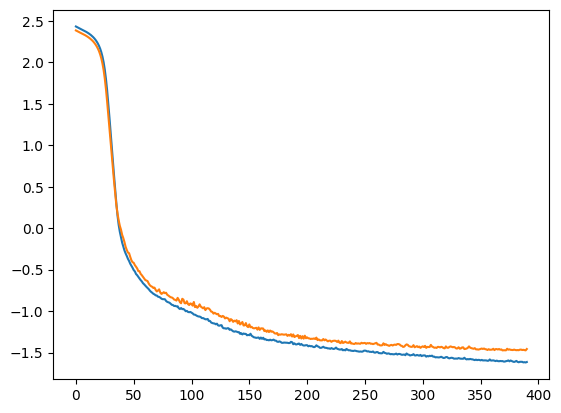

In [19]:
plt.plot(losses)
plt.show()

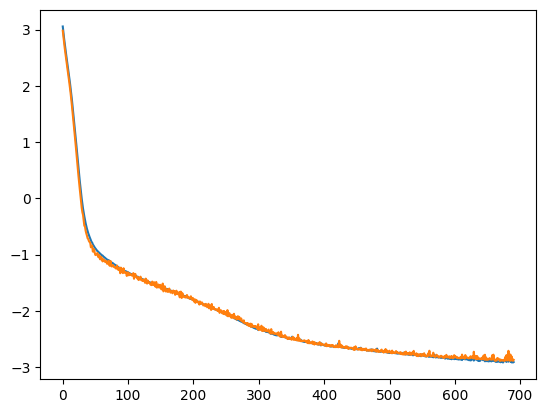

In [17]:
plt.plot(losses)
plt.show()

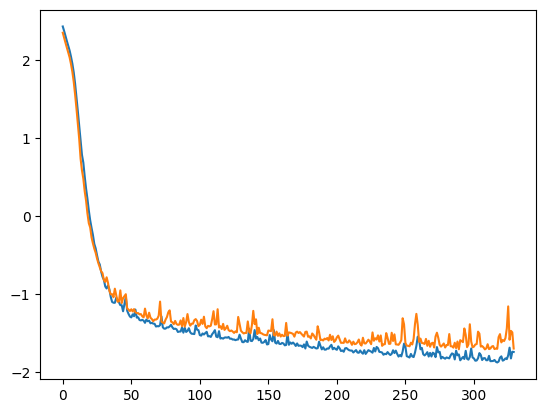

In [49]:
plt.plot(losses)
plt.show()

## run through ltu-ili for comprehensive posterior comparison

In [20]:
data['y'].shape

(500, 4, 128, 128)

In [19]:
# get embedding summaries from mdn networks
key = jr.PRNGKey(200)
keys = jr.split(key, num=data['y'].shape[0])

# map noise over the dataset
chunk = 100
noisy_data = jnp.concatenate([jax.vmap(noise_simulator)(keys[i*chunk:(i+1)*chunk],\
                                                        data['y'][i*chunk:(i+1)*chunk]) \
                                                        for i in range(data['y'].shape[0]//chunk)], axis=0)

appfn = lambda d: model.model.apply(w, x=d, rng=jr.PRNGKey(400), method='embedding')

summs = jnp.concatenate([appfn(noisy_data[i*chunk:(i+1)*chunk]) \
                          for i in range(noisy_data.shape[0]//chunk)], axis=0)

summs.shape,# summs_vanilla.shape

((500, 63),)

In [25]:
summs.shape

(500, 63)

In [21]:
noisevars

Array([0.00045021, 0.00087473, 0.00134725, 0.00183411], dtype=float32)

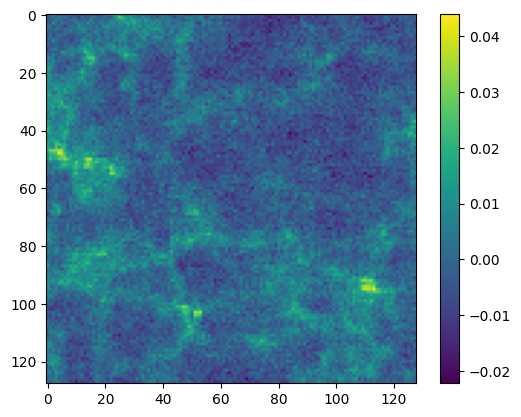

In [22]:
plt.imshow(noisy_data[334, 1, ...])
plt.colorbar()
plt.show()
plt.close()

In [23]:
noisy_data.shape

(500, 4, 128, 128)

In [24]:
chunk = 100
summs_cls = jnp.concatenate([jax.vmap(embed_model.cl_compression)(noisy_data[i*chunk:(i+1)*chunk]) \
                          for i in range(noisy_data.shape[0]//chunk)], axis=0).reshape(-1, 60)

In [26]:
np.savez("epe_N128_summaries_noise12_ncomp4_nouts3_epe_net_3out_nsim500",
         summaries=summs,
         summaries_cls=summs_cls,
         theta=data['theta'])

In [25]:
#summs = np.load("epe_N128_summaries_noise12_ncomp4_nouts3.npz")["summaries"]
#summs_cls = np.load("epe_N128_summaries_noise12_ncomp4_nouts3.npz")["summaries_cls"]

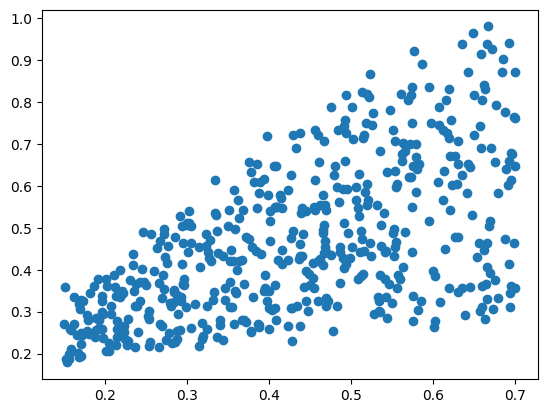

In [27]:
plt.scatter(data['theta'][:, 0], summs[:, -1])
plt.show()
plt.close()

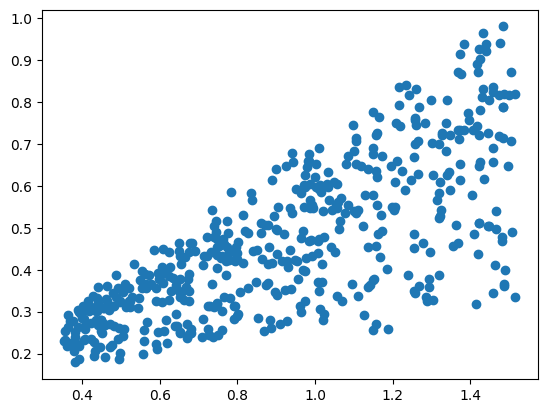

In [28]:
plt.scatter(data['theta'][:, 1], summs[:, -1])
plt.show()
plt.close()

In [29]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [59]:
# make a dataloader for the predicted thetas and true thetas
#loader = NumpyLoader(x=np.concatenate([np.array(summs), summs_cls], axis=-1), theta=np.array(data['theta']))

In [30]:
loader = NumpyLoader(x=np.array(summs),
                     theta=np.array(data['theta']))

# CONCATENATE summaries
#loader = NumpyLoader(x=np.concatenate([np.array(summs), summs_cls], axis=-1), theta=np.array(data['theta']))

# define a prior for the scaled thetas
low=[0.15, 0.35]; high=[0.7, 1.52]
prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    #ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=50, num_transforms=5)
]

nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=12),
    #ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [31]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 80 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


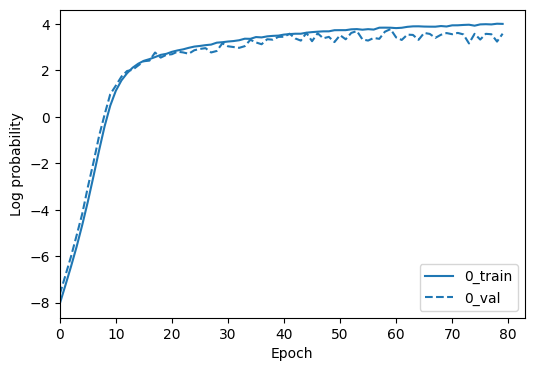

In [32]:
# FOR CNN + PK summaries

fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

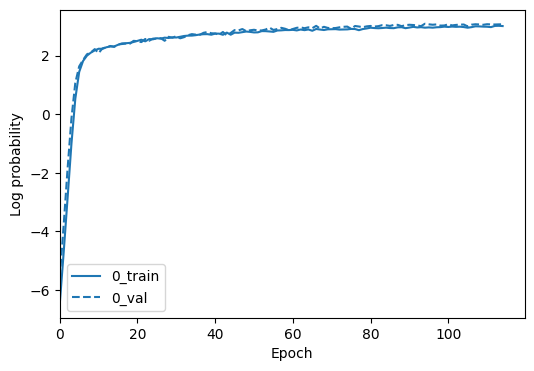

In [62]:
# plot train/validation loss -- FOR CNN ALONE (VMIM)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

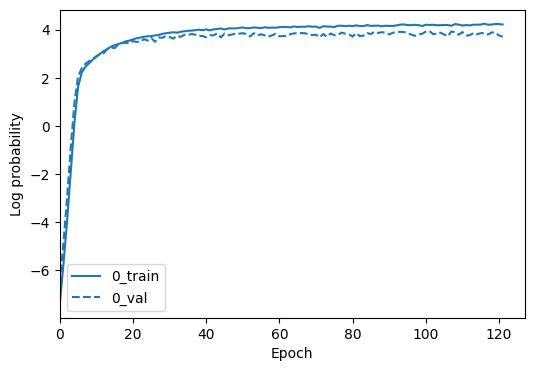

In [31]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [26]:
plt.imshow(target_data[1, ...])
plt.colorbar()
plt.show()

NameError: name 'target_data' is not defined

In [36]:
# choose a random input
seed_in = 459
np.random.seed(seed_in)
#ind = np.random.randint(len(data['theta']))
theta = np.array(data['theta'])

ind = np.argmin(((theta - np.array([0.3, 0.8]))**2).sum(-1))

key = jr.PRNGKey(22)
target_data = np.load("/data101/makinen/lemur_sims/pm_sims/target_L_250_N_128_Nz_512.npz")["kappa"]
target_data = noise_simulator(key, target_data) # add noise
target_theta = np.load("/data101/makinen/lemur_sims/pm_sims/target_L_250_N_128_Nz_512.npz")["theta"]

# get summaries
target_cls_x = np.array(embed_model.cl_compression(target_data)).reshape(-1)
target_x =  np.array(model.model.apply(w, x=target_data[jnp.newaxis, ...], rng=jr.PRNGKey(3), method='embedding'))

# concatenate summaries
#target_x = np.concatenate([target_x.reshape(-1), target_cls_x], 0)

#target_theta = theta[ind]
print("target", target_theta)

#target_x = np.array(summs)[ind]
#target_cls_x = np.array(summs_cls)[ind]

print(target_theta)

#target_x_vanilla = np.array(summs_vanilla)[ind]

target [0.3   0.811]
[0.3   0.811]


In [37]:
np.savez("epe_N128_summaries_noise12_ncomp4_nouts3_lowtrainingdata_n500_epe_3outs",
         summaries_epe=summs,
         summaries_cls=summs_cls,
         target_cls=target_cls_x,
         target_x=target_x,
         theta=data['theta'])

In [38]:
target_cls_x.shape, target_x.shape


((60,), (1, 63))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

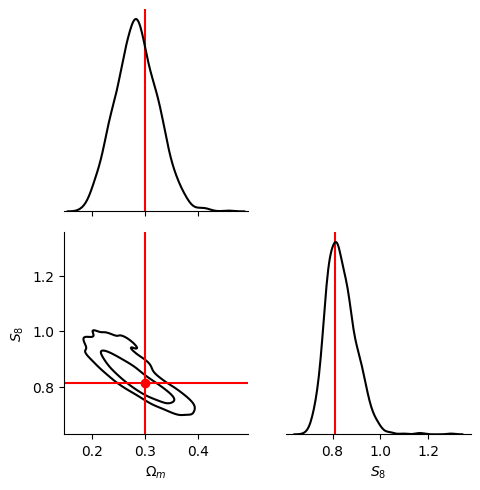

In [39]:
# use ltu-ili's built-in validation metrics to plot the posterior for this set of galaxies !

params = [r'$\Omega_m$', r'$S_8$']

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = target_x, theta_fid=target_theta
)
plt.show()

## now for cls

In [85]:
# make a dataloader for the predicted thetas and true thetas
loader = NumpyLoader(x=np.array(summs_cls), theta=np.array(data['theta']))

# define a prior for the scaled thetas
low=[0.15, 0.35]; high=[0.7, 1.52]
prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=12)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner2 = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

# train the model
posterior_ensemble2, summaries2 = runner2(loader=loader)

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 85 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


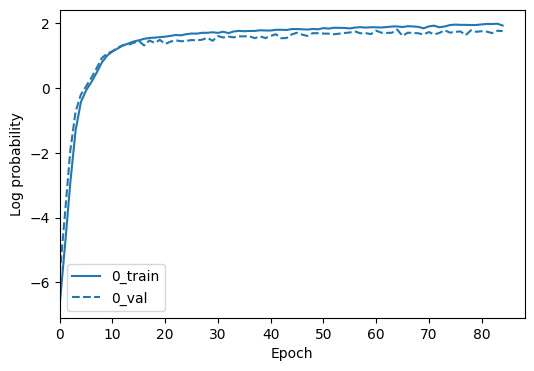

In [86]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries2):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

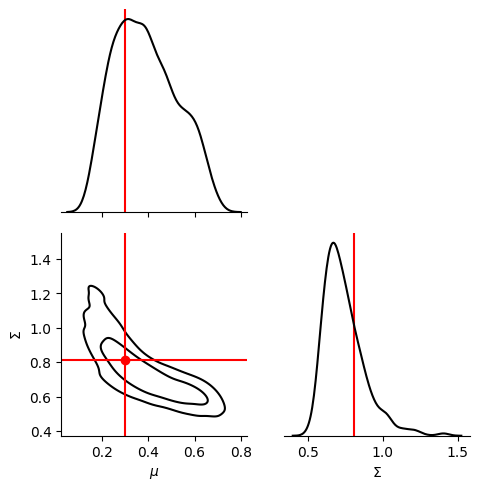

In [87]:
# use ltu-ili's built-in validation metrics to plot the posterior for this set of galaxies !

params = [r'$\mu$', r'$\Sigma$']

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble2,
    x_obs = target_cls_x, theta_fid=target_theta
)
plt.show()

# plot in chainconsumer

In [54]:
samples = posterior_ensemble.sample((10000,), torch.Tensor(target_x).to(device)).cpu().numpy()
samples_cls = posterior_ensemble2.sample((10000,), torch.Tensor(target_cls_x).to(device)).cpu().numpy()


#samples_cls = get_sigma8(samples_cls)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T


samples = posterior_ensemble.sample((100000,), torch.Tensor(target_x).to(device)).cpu().numpy()
#samples_cls = get_S8(np.load("results_target_N128_epe_noise12_ncomp4_optimiser.npz")["chains_cls"])
#samples_cls = posterior_ensemble2.sample((10000,), torch.Tensor(target_cls_x).to(device)).cpu().numpy()


chains_epe_hybrid = get_S8(np.load("results_target_N128_epe_noise12_lowtrainingdata.npz")["chains_epe"])
samples_cls = get_S8(np.load("results_target_N128_epe_noise12_lowtrainingdata_comp_nouts3_vmim_concat.npz")["chains_cls"])

samples_vmim = get_S8(np.load("results_target_N128_epe_noise12_lowtrainingdata_comp_nouts3_vmim_concat.npz")["chains_vmim"])



Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

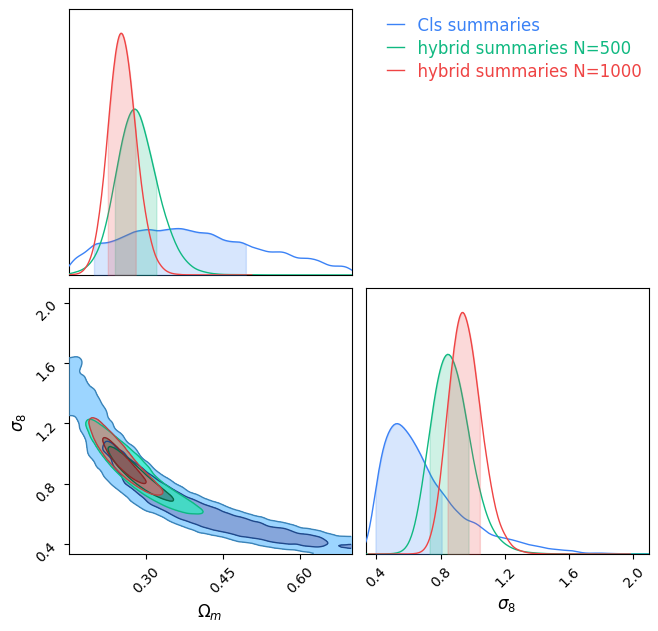

In [50]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

params = [r'$\Omega_m$', r'$\sigma_8$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

dfvmim = pd.DataFrame(get_sigma8(samples), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df = pd.DataFrame(get_sigma8(chains_epe_hybrid), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="Cls summaries"))
c.add_chain(Chain(samples = dfvmim, name="hybrid summaries N=500"))

c.add_chain(Chain(samples=df, name="hybrid summaries N=1000",))
#c.add_truth(Truth(location={params[0]: target_theta[0], params[1]: target_theta[1]}))


fig = c.plotter.plot()
plt.show()

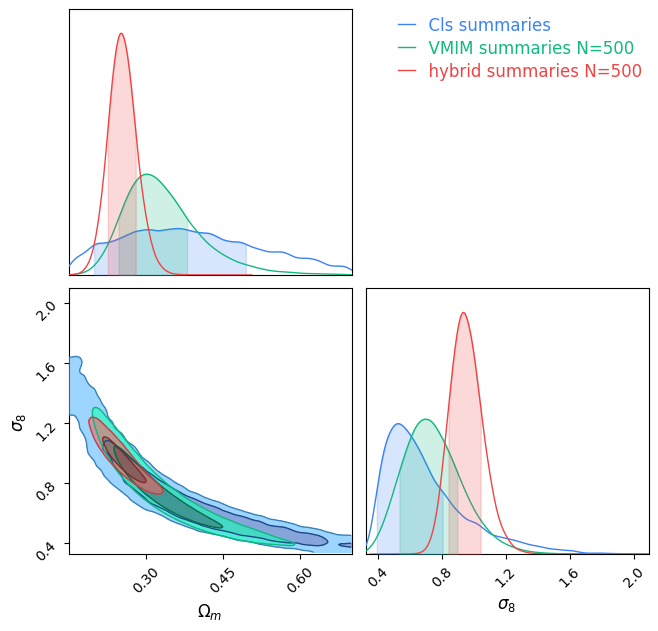

In [46]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

params = [r'$\Omega_m$', r'$\sigma_8$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

dfvmim = pd.DataFrame(get_sigma8(samples_vmim), columns=[r'$\Omega_m$', r'$\sigma_8$'])

df = pd.DataFrame(get_sigma8(chains_epe_hybrid), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="Cls summaries"))
c.add_chain(Chain(samples = dfvmim, name="VMIM summaries N=1000"))

c.add_chain(Chain(samples=df, name="hybrid summaries N=500",))
#c.add_truth(Truth(location={params[0]: target_theta[0], params[1]: target_theta[1]}))


fig = c.plotter.plot()
plt.show()

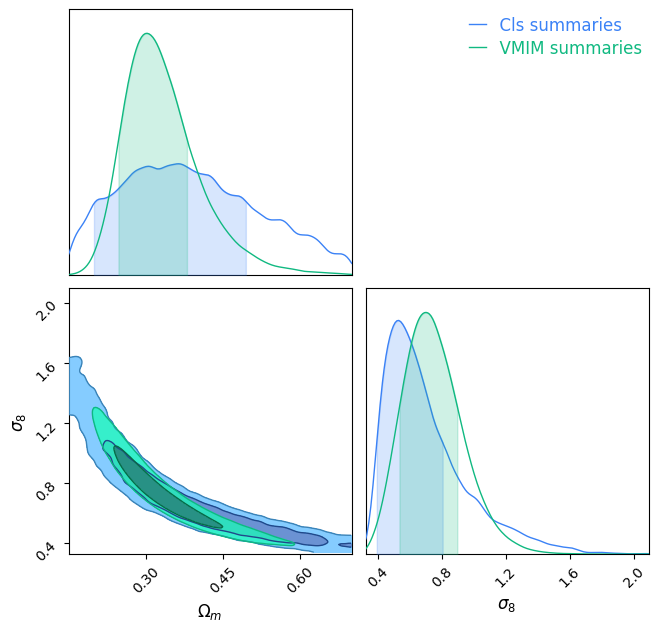

In [94]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T


# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame(get_sigma8(samples), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="Cls summaries"))

c.add_chain(Chain(samples=df, name="VMIM summaries",))


fig = c.plotter.plot()
plt.show()

In [51]:
np.savez("results_target_N128_epe_noise12_lowtrainingdata_comp_nouts3_vmim_concat_epe_n500",
         #chains_imnn=old_results,
         chains_epe_n500=get_sigma8(samples),
         chains_vmim=get_sigma8(samples_vmim),
         chains_epe=get_sigma8(chains_epe_hybrid),
         chains_cls=get_sigma8(samples_cls))

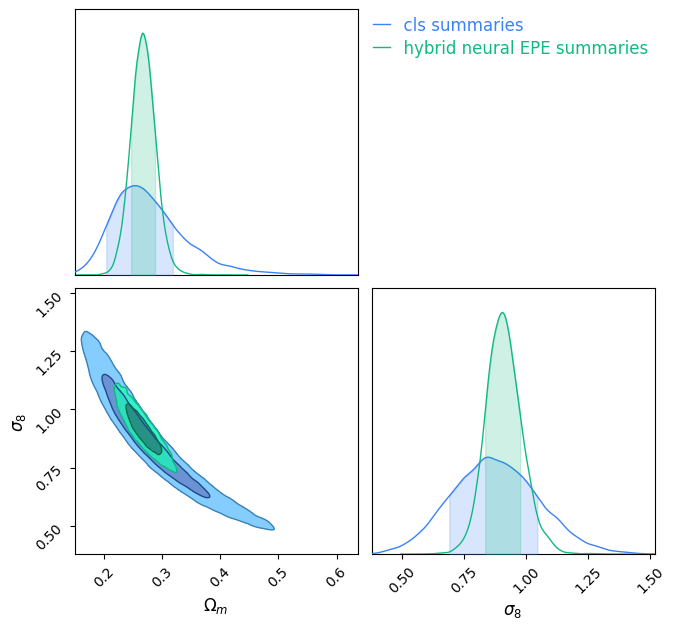

In [62]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T


# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame(get_sigma8(samples), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="cls summaries"))

c.add_chain(Chain(samples=df, name="hybrid neural EPE summaries",))


fig = c.plotter.plot()
plt.show()

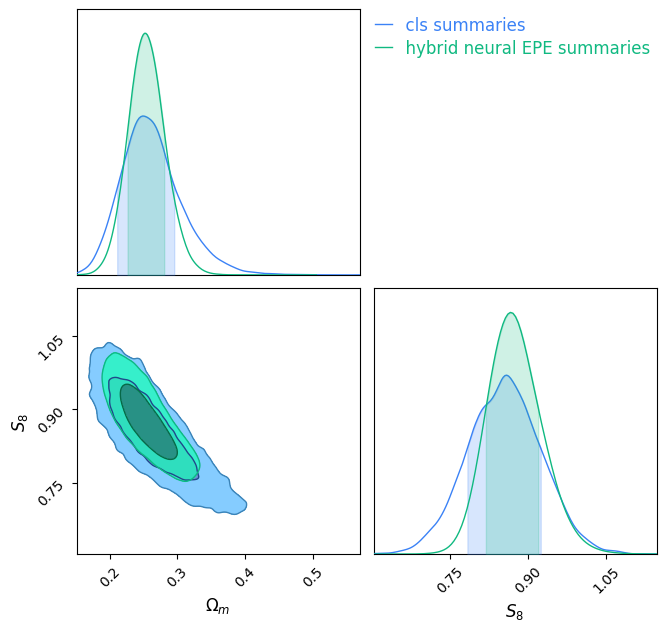

In [41]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

df = pd.DataFrame((samples), columns=[r'$\Omega_m$', r'$S_8$'])

# samples_cls = get_sigma8(samples_cls.cpu().numpy()
df_cls = pd.DataFrame((samples_cls), columns=[r'$\Omega_m$', r'$S_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="cls summaries"))

c.add_chain(Chain(samples=df, name="hybrid neural EPE summaries",))


fig = c.plotter.plot()
plt.show()

In [57]:
old_results = np.load("results_target_PM_L250_N128_smallerprior_ensemble.npz")["chains_imnn"]
old_cls_chains = np.load("results_target_PM_L250_N128_smallerprior_ensemble.npz")["chains_moped"]

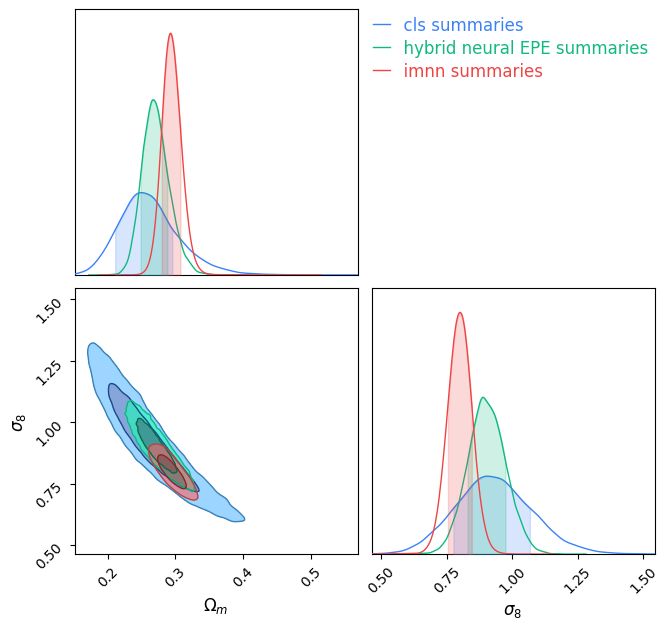

In [58]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

#samples_cls = get_sigma8(samples_cls.cpu().numpy()

df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_imnn = pd.DataFrame((old_results), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df = pd.DataFrame(get_sigma8(samples), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="cls summaries"))


c.add_chain(Chain(samples=df, name="hybrid neural EPE summaries",))
c.add_chain(Chain(samples = df_imnn, name="imnn summaries"))



fig = c.plotter.plot()
plt.show()

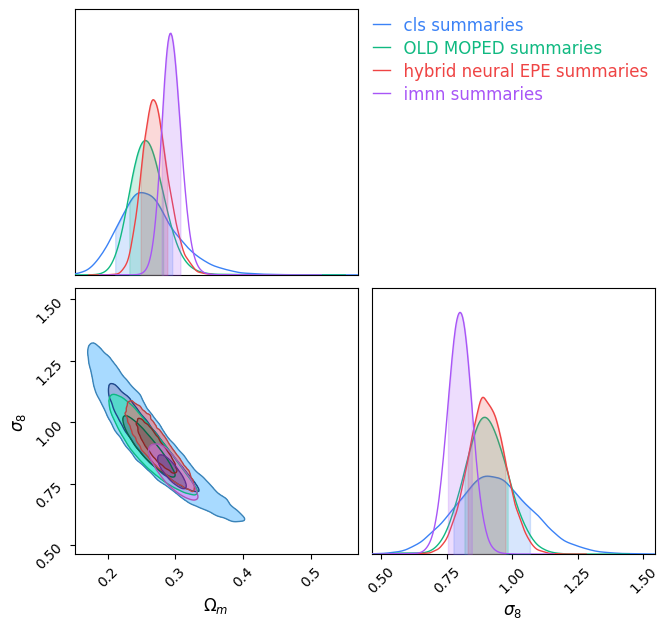

In [59]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

#samples_cls = get_sigma8(samples_cls.cpu().numpy()

df_cls = pd.DataFrame(get_sigma8(samples_cls), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df_imnn = pd.DataFrame((old_results), columns=[r'$\Omega_m$', r'$\sigma_8$'])
df = pd.DataFrame(get_sigma8(samples), columns=[r'$\Omega_m$', r'$\sigma_8$'])

df_cls_old = pd.DataFrame((old_cls_chains), columns=[r'$\Omega_m$', r'$\sigma_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="cls summaries"))

c.add_chain(Chain(samples = df_cls_old, name="OLD MOPED summaries"))


c.add_chain(Chain(samples=df, name="hybrid neural EPE summaries",))
c.add_chain(Chain(samples = df_imnn, name="imnn summaries"))



fig = c.plotter.plot()
plt.show()

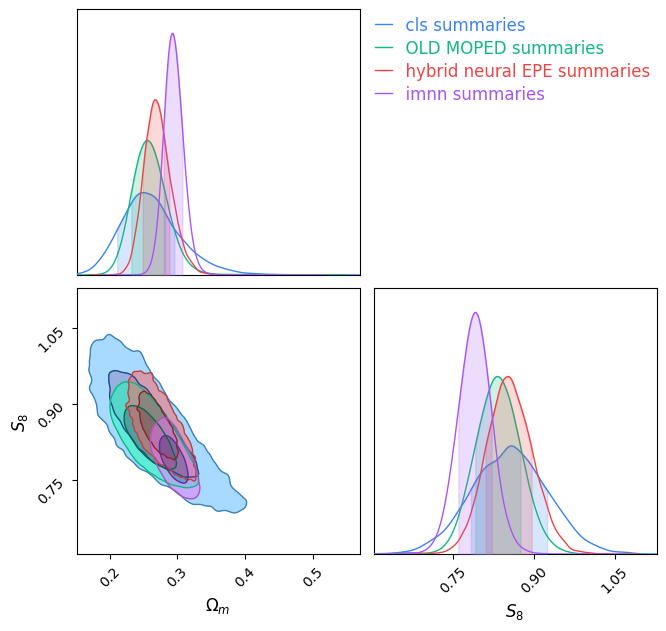

In [61]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T


df_cls = pd.DataFrame((samples_cls), columns=[r'$\Omega_m$', r'$S_8$'])
df = pd.DataFrame((samples), columns=[r'$\Omega_m$', r'$S_8$'])
df_imnn = pd.DataFrame(get_S8(old_results), columns=[r'$\Omega_m$', r'$S_8$'])

df_cls_old = pd.DataFrame(get_S8(old_cls_chains), columns=[r'$\Omega_m$', r'$S_8$'])


c = ChainConsumer()
c.add_chain(Chain(samples = df_cls, name="cls summaries"))

c.add_chain(Chain(samples = df_cls_old, name="OLD MOPED summaries"))

c.add_chain(Chain(samples=df, name="hybrid neural EPE summaries",))
c.add_chain(Chain(samples = df_imnn, name="imnn summaries"))



fig = c.plotter.plot()
plt.show()

In [62]:
np.savez("results_target_N128_epe_noise12_ncomp4_optimiser",
         chains_imnn=old_results,
         chains_epe=get_sigma8(samples),
         chains_cls=get_sigma8(samples_cls))

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


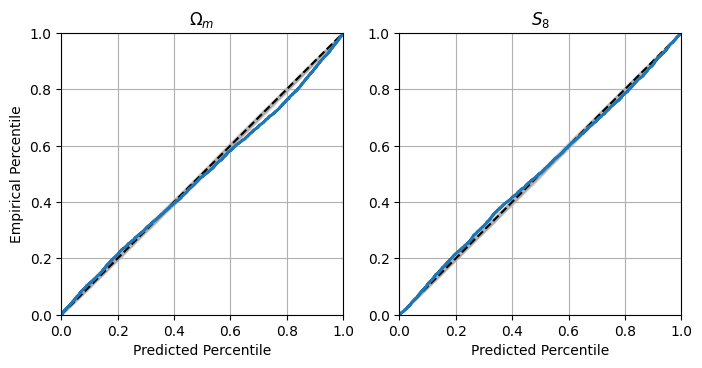

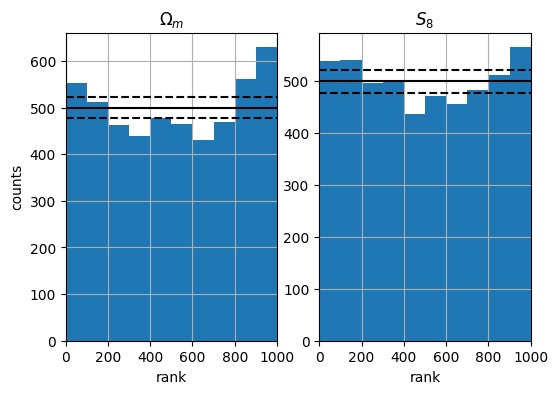

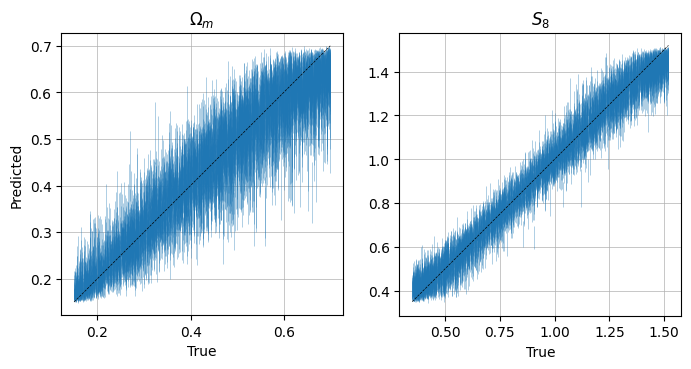

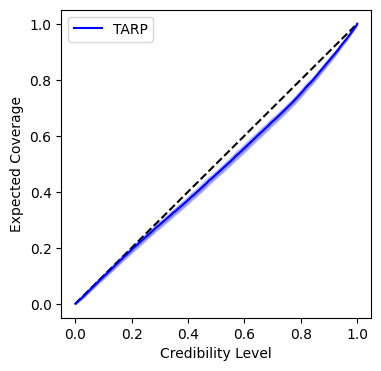

In [68]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=[r"$\Omega_m$", r"$S_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=np.array(summs), theta=np.array(data['theta'])
)
plt.show()

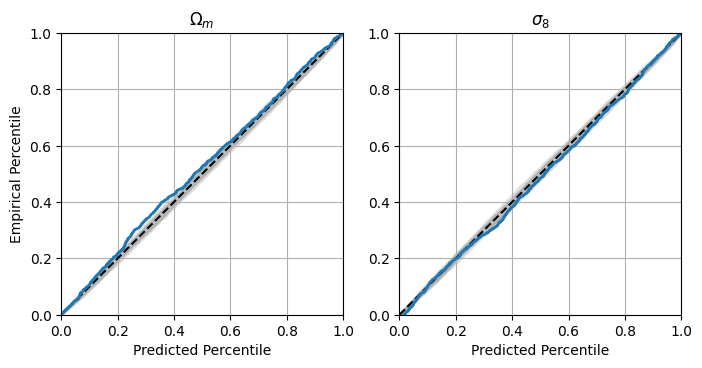

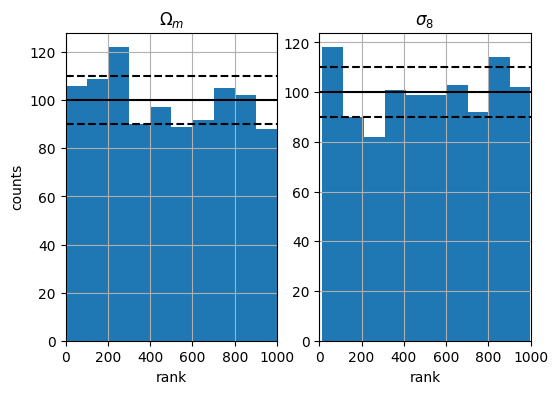

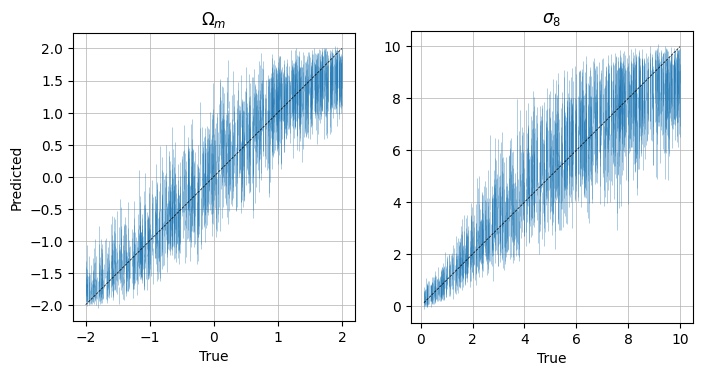

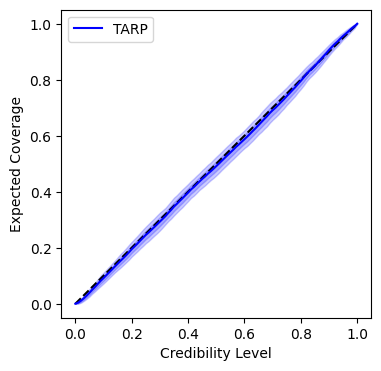

In [ ]:
plt.show()